In [1]:
'''
This Python code loads localization data of particles from three different channels of an experiment, 
performs particle tracking, and creates a plot of the tracked particles.
We use a sparse sample and gather many localizations by raster-tiling the sample
Beads are localized per frame, and localizations are then combined and tracked.

'''




'\nThis Python code loads localization data of particles from three different channels of an experiment, \nperforms particle tracking, and creates a plot of the tracked particles.\nWe use a sparse sample and gather many localizations by raster-tiling the sample\nBeads are localized per frame, and localizations are then combined and tracked.\n\n'

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml as yaml
import trackpy as tp
# import naclib.stpol
# import naclib.util

### Define functions for loading data and tracking

def load_locs(file, trackID='track.id', t='t'):
    """
    Load (simulated) loc files into dataframes and change dataframe.columns
    from swift-compatible to trackpy compatible and for better codability.
    """
    locs = pd.read_csv(file)
    info = load_info(file)
    if trackID in locs.columns:
        locs.rename(columns={trackID: 'particle'}, inplace=True)
        locs.rename(columns={t: 'frame'}, inplace=True)
    return (locs, info)

def load_info(path, qt_parent=None):
    path_base, path_extension = os.path.splitext(path)
    filename = path_base + ".yaml"
    with open(filename, "r") as info_file:
        info = list(yaml.load_all(info_file, Loader=yaml.FullLoader))
    return info

# Define a function to perform particle tracking on localization data
def apply_tracking(df_locs_all):
    df_linked = tp.link(df_locs_all,
                        search_range=20,
                        memory=0,
                        link_strategy='hybrid',
                        )
    df_linked = df_linked.rename(columns={'particle': 'track.id',
                                          'frame': 't'})

    # add column with length of track
    loc_count = df_linked['track.id'].value_counts()
    loc_count = loc_count.reset_index(
        name='loc_count').rename(columns={'index': 'track.id'})

    df_linked = df_linked.merge(loc_count, on='track.id')
    df_linked = df_linked.sort_values(['t', 'track.id'])
        
    return df_linked

def get_unique_trackIDs(df, group="cell_id"):
    # highest track_id per group, cumulated over groups and shifted one group down
    track_id_max = df.groupby([group])["track.id"].max() + 1
    track_id_cum = track_id_max.cumsum().shift(1, fill_value=0)

    df["track.id"] = df["track.id"] + \
        np.array(track_id_cum)[df[group].factorize()[0]]
    df["track.id"] = df["track.id"].astype(int)

    return df

# Define the path to the directory containing the experiment data
path = r'D:\20230421 tetraspeck\Run00017'

# Generate a list of file paths for the localization CSV of the files of all three channels
paths = glob.glob(path+'/*locs.csv')

# Load localization data from the CSV files
df_locs0, info = load_locs(paths[0])
df_locs1, info = load_locs(paths[1])
df_locs2, info = load_locs(paths[2])

# Combine the localizations from all channels into a single DataFrame and rename columns
# We want to assign the bead position in one channel to the respective positions in the other channels
# Therefore, we use the 'frame' column for the different channels
# The actual frame column is renamed to 'grid' and is only   

df_locs_all = pd.concat([df_locs0, df_locs1, df_locs2], keys=['0', '1', '2']).reset_index(
    level=0).rename(columns={'t': 'grid', 'level_0': 'frame'})

df_locs_all.head()


,frame,grid,x,y,intensity,sx,sy,bg,lpx,lpy,ellipticity,net_gradient,loc_precision,nearest_neighbor
0,0,0,51.086500,428.82623,19691.840,1.781357,1.490991,78.633700,0.026384,0.021695,0.163003,30926.648,0.024039,57.037067
1,0,0,73.333150,336.57140,28729.945,1.770485,1.656289,90.415726,0.021337,0.019845,0.064500,36668.336,0.020591,77.062232
2,0,0,85.709526,474.15253,11865.251,1.561334,1.463506,49.831050,0.029471,0.027475,0.062657,22742.012,0.028473,43.237782
3,0,0,87.909800,517.33430,20391.260,1.654282,1.545324,51.825930,0.023271,0.021661,0.065864,35771.070,0.022466,43.237782
4,0,0,111.674840,661.14050,12584.068,1.700517,1.629641,29.190310,0.030374,0.029042,0.041679,19392.172,0.029708,103.659531


Frame 2: 67 trajectories present.


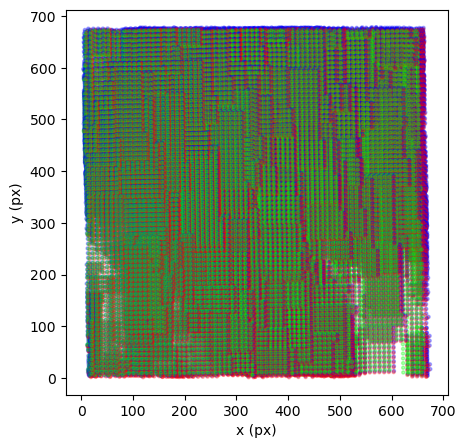

In [7]:
# Apply the tracking function to each group of localizations by grid value
df_tracks = df_locs_all.groupby('grid').apply(
    apply_tracking).reset_index(level=0, drop=True)


# Filter the tracked localizations to only include tracks with more than 2 localizations
df_tracks = df_tracks.loc[df_tracks.loc_count ==3]

# Ensure each track has a unique ID
df_tracks = get_unique_trackIDs(df_tracks, group='grid')

# Save the tracked localizations to a CSV file
df_tracks.to_csv(r'D:\tracked.csv')

# Create a scatter plot of the tracked localizations
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax = df_tracks.plot.scatter(x='x', y='y', c='t', colormap='brg',
                            marker='.', colorbar=False, ax=ax, alpha=0.3)
ax.set_xlabel('x (px)')
ax.set_ylabel('y (px)')
ax.set_aspect('equal')

# Save the plot as a PNG file
plt.savefig(os.path.join(path, 'plots', '_uncorrected.png'),
            dpi=200, bbox_inches='tight', transparent=False)

# Create a list of x and y coordinates of localizations at time points 0, 1, and 2
points = [df_tracks.loc[df_tracks.t == i, ['x', 'y']].values for i in [0, 1, 2]]

In [8]:
import naclib.stpol
import naclib.util
'''
Rescale to unit circle.
'''
fig_size = [
    682, 682]  # Original image (channel) size, needed for rescaling to unit circle.
locs0_scaled, scale = naclib.util.loc_to_unitcircle(points[0], fig_size)
locs1_scaled, scale = naclib.util.loc_to_unitcircle(points[1], fig_size)
locs2_scaled, scale = naclib.util.loc_to_unitcircle(points[2], fig_size)

'''
Get distortion grid.
'''
D0 = np.zeros(locs0_scaled.shape)
D0[:, 0] = locs1_scaled[:, 0] - locs0_scaled[:, 0]
D0[:, 1] = locs1_scaled[:, 1] - locs0_scaled[:, 1]

D2 = np.zeros(locs2_scaled.shape)
D2[:, 0] = locs1_scaled[:, 0] - locs2_scaled[:, 0]
D2[:, 1] = locs1_scaled[:, 1] - locs2_scaled[:, 1]

# channel0error = np.zeros([15,15])
# channel2error = np.zeros([15,15])


j_max_S = 10  # Max term for S polynomials.
j_max_T = 10  # Max term for T polynomials.

# Get ST polynomial decomposition coefficients.
stpol = naclib.stpol.STPolynomials(j_max_S=j_max_S, j_max_T=j_max_T)
a_S0, a_T0 = stpol.get_decomposition(locs0_scaled, D0)
a_S2, a_T2 = stpol.get_decomposition(locs2_scaled, D2)


# Save resulting coefficients.
df_coefs = pd.DataFrame(columns=['channel', 'type', 'term', 'value'])
for term, value in a_S0.items():
    df_coefs = df_coefs.append(
        {'channel': '0', 'type': 'S', 'term': term, 'value': value}, ignore_index=True)
for term, value in a_T0.items():
    df_coefs = df_coefs.append(
        {'channel': '0', 'type': 'T', 'term': term, 'value': value}, ignore_index=True)
for term, value in a_S2.items():
    df_coefs = df_coefs.append(
        {'channel': '2', 'type': 'S', 'term': term, 'value': value}, ignore_index=True)
for term, value in a_T2.items():
    df_coefs = df_coefs.append(
        {'channel': '2', 'type': 'T', 'term': term, 'value': value}, ignore_index=True)

df_coefs = df_coefs.append({'value': path}, ignore_index=True)

df_coefs.to_csv(os.path.join(path, 'plots', '_naclib_coefficients.csv'))




Convergence at iteration  32 with mean error  0.00030100759894653955
Convergence at iteration  46 with mean error  0.0005606839030266593


In [9]:
'''
Prepare plots.
'''
theta = np.linspace(0, 2*np.pi, 100)

# Distortion field
magnitude0 = np.hypot(D0[:, 0], D0[:, 1]) * scale
magnitude2 = np.hypot(D2[:, 0], D2[:, 1]) * scale
magnitude_max = np.max([np.max(magnitude0), np.max(magnitude2)])

# Correction field
P0 = stpol.get_field(locs0_scaled, a_S0, a_T0)
magnitude_P0 = np.hypot(P0[:, 0], P0[:, 1]) * scale
P2 = stpol.get_field(locs2_scaled, a_S2, a_T2)
magnitude_P2 = np.hypot(P2[:, 0], P2[:, 1]) * scale

# Residual distortion field
locs0_scaled_corrected = locs0_scaled + P0
D_res0 = np.zeros(locs0_scaled_corrected.shape)
D_res0[:, 0] = locs1_scaled[:, 0] - locs0_scaled_corrected[:, 0]
D_res0[:, 1] = locs1_scaled[:, 1] - locs0_scaled_corrected[:, 1]
magnitude_res0 = np.hypot(D_res0[:, 0], D_res0[:, 1]) * scale

locs2_scaled_corrected = locs2_scaled + P2
D_res2 = np.zeros(locs2_scaled_corrected.shape)
D_res2[:, 0] = locs1_scaled[:, 0] - locs2_scaled_corrected[:, 0]
D_res2[:, 1] = locs1_scaled[:, 1] - locs2_scaled_corrected[:, 1]
magnitude_res2 = np.hypot(D_res2[:, 0], D_res2[:, 1]) * scale


0.14515995882337707 0.2703880319338227


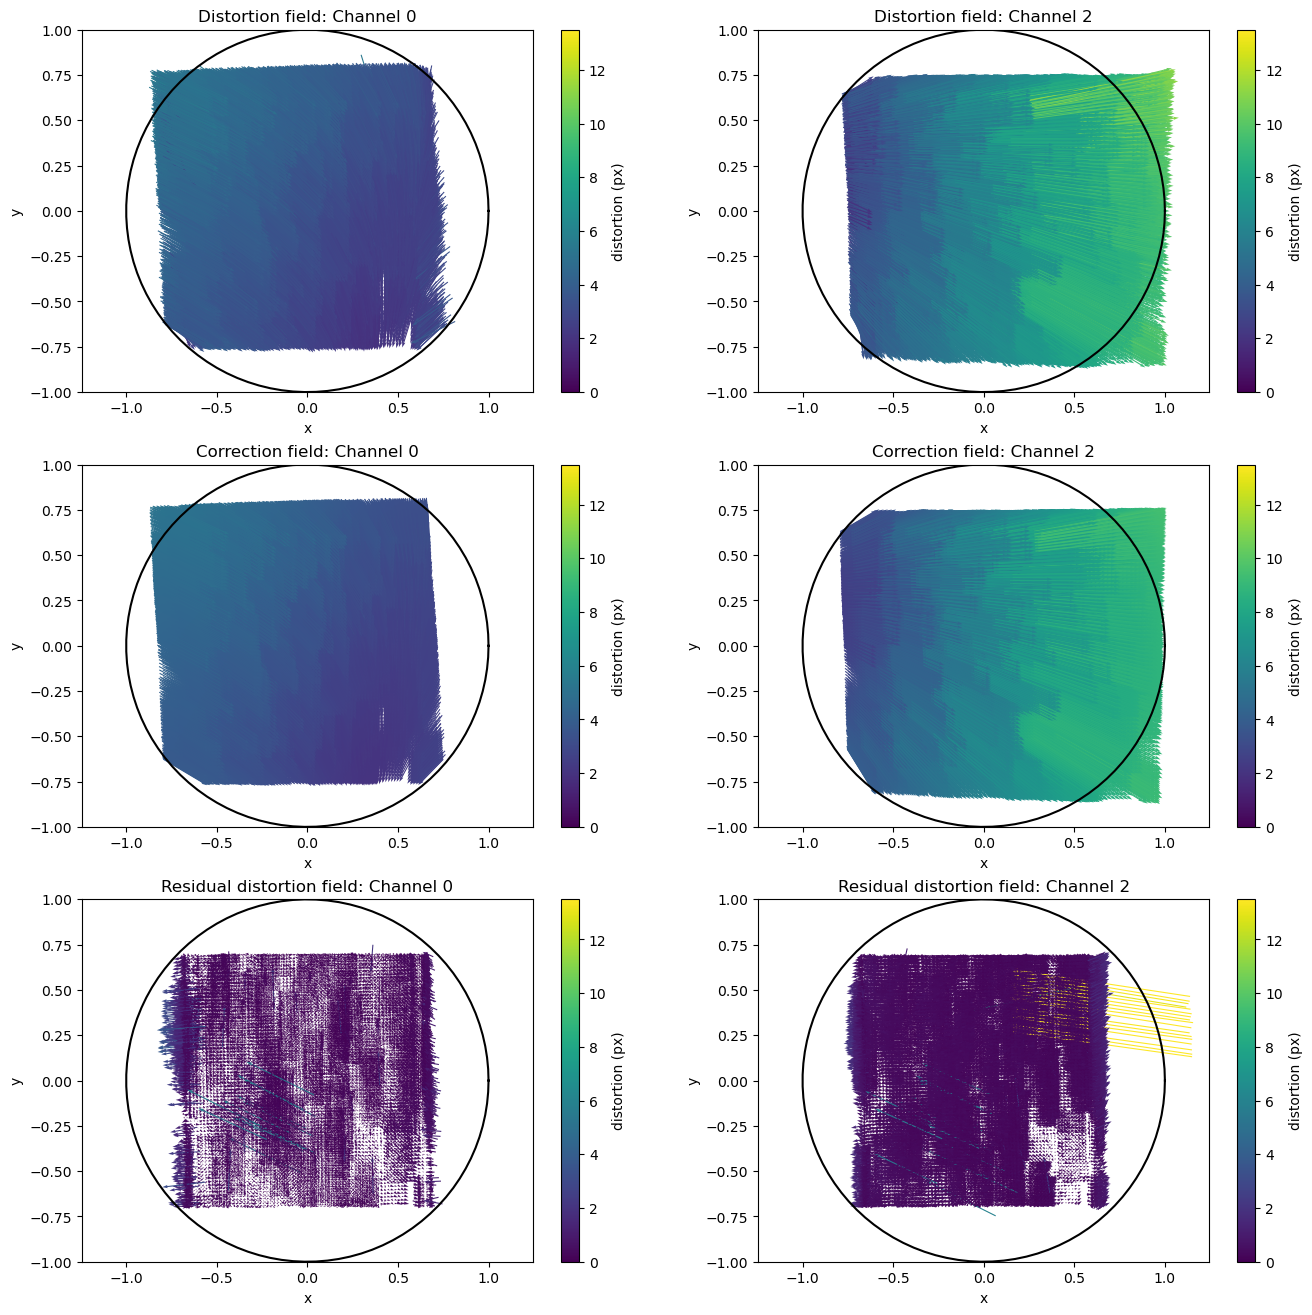

In [10]:
'''
Plot
'''
# Plot distortion fields.
fig = plt.figure(figsize=(16, 16))
ax0 = fig.add_subplot(321)
q0 = plt.quiver(locs0_scaled[:, 0], locs0_scaled[:, 1], D0[:, 0], D0[:, 1],
                magnitude0, pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)

plt.plot(np.cos(theta), np.sin(theta), c='k')
clb = plt.colorbar(q0)
plt.title('Distortion field: Channel 0')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))


ax1 = fig.add_subplot(322)
q2 = plt.quiver(locs0_scaled[:, 0], locs0_scaled[:, 1], D2[:, 0], D2[:, 1],
                magnitude2, pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)
plt.plot(np.cos(theta), np.sin(theta), c='k')
clb = plt.colorbar(q2)
plt.title('Distortion field: Channel 2')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))

# Plot correction fields.
ax0 = fig.add_subplot(323)
q0 = plt.quiver(locs0_scaled[:, 0], locs0_scaled[:, 1], P0[:, 0], P0[:, 1], magnitude_P0,
                pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)
clb = plt.colorbar(q0)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Correction field: Channel 0')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))

ax1 = fig.add_subplot(324)
q2 = plt.quiver(locs0_scaled[:, 0], locs0_scaled[:, 1], P2[:, 0], P2[:, 1], magnitude_P2,
                pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)
clb = plt.colorbar(q2)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Correction field: Channel 2')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))


# Plot residual distortion fields.
ax0 = fig.add_subplot(325)
q0 = plt.quiver(locs0_scaled[:, 0], locs0_scaled[:, 1], D_res0[:, 0], D_res0[:, 1], magnitude_res0,
                pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)
clb = plt.colorbar(q0)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Residual distortion field: Channel 0')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))

ax1 = fig.add_subplot(326)
q2 = plt.quiver(locs2_scaled[:, 0], locs2_scaled[:, 1], D_res2[:, 0], D_res2[:, 1], magnitude_res2,
                pivot='mid', clim=(0, 1.2 * magnitude_max), scale=0.07)
clb = plt.colorbar(q2)
plt.plot(np.cos(theta), np.sin(theta), c='k')
plt.title('Residual distortion field: Channel 2')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('distortion (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plt.savefig(os.path.join(path, 'plots', '_fields'+str(j_max_S) +
            str(j_max_T)+'.png'), dpi=200, bbox_inches='tight', transparent=False)

print(str(np.mean(magnitude_res0)), str(np.mean(magnitude_res2)))

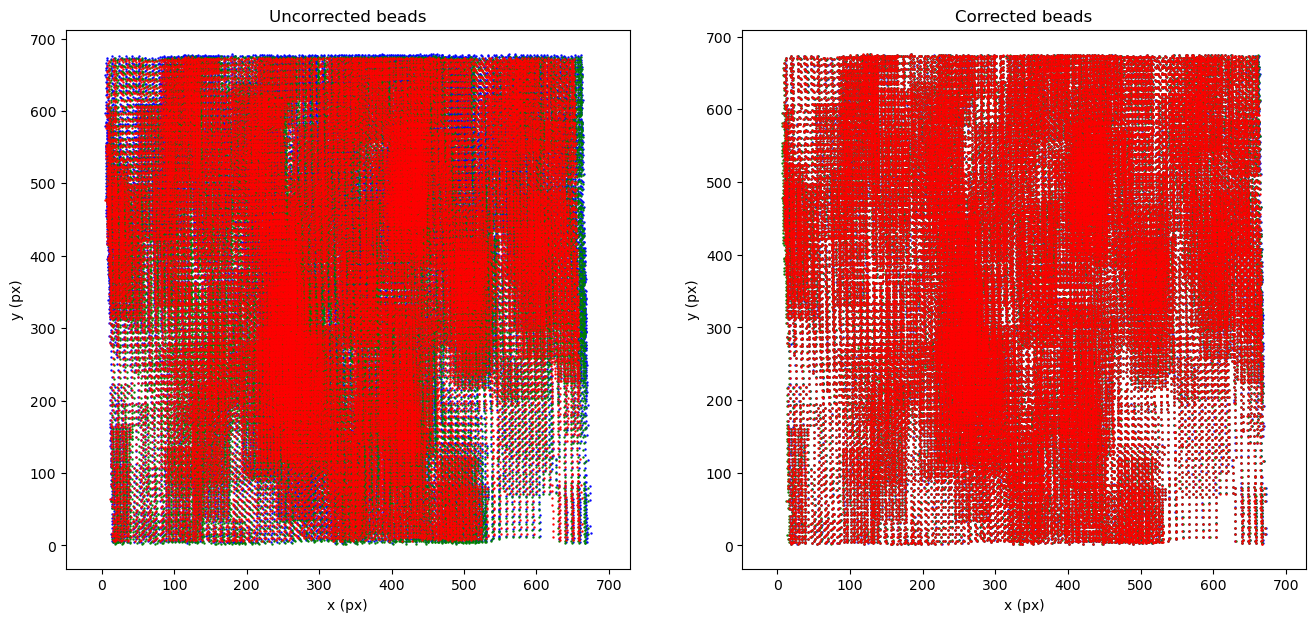

In [11]:
#%%
# Correct spot locations, scale back from unit circle to original scale, and save.
locs0_corrected = locs0_scaled_corrected + P0
locs2_corrected = locs2_scaled_corrected + P2

locs0_corrected = naclib.util.unitcircle_to_loc(locs0_scaled_corrected, fig_size)
locs2_corrected = naclib.util.unitcircle_to_loc(locs2_scaled_corrected, fig_size)


# Show localization improvement
# Original grid.
fig = plt.figure(figsize=(16, 7))
fig.add_subplot(121)
plt.title('Original spots - center of image')
color = ['b', 'g', 'r']
for k in [0, 1, 2]:
    plt.scatter(points[k][:, 0], points[k][:, 1], c=color[k], marker='.', s=2)
    plt.xlabel('x (px)')
    plt.ylabel('y (px)')
    plt.axis('equal')
    plt.title('Uncorrected beads')
    # plt.legend(['Channel 0','Channel 1','Channel 2'])

# Corrected grid.
fig.add_subplot(122)
plt.scatter(locs0_corrected[:, 0], locs0_corrected[:, 1], c='b', marker='.', s=2)
plt.scatter(points[1][:, 0], points[1][:, 1], c='g', marker='.', s=2)
plt.scatter(locs2_corrected[:, 0], locs2_corrected[:, 1], c='r', marker='.', s=2)
plt.xlabel('x (px)')
plt.ylabel('y (px)')
plt.axis('equal')
plt.title('Corrected beads')
# plt.legend(['Channel 0','Channel 1','Channel 2'])
plt.savefig(os.path.join(path, 'plots', '_corrected.png'),
            dpi=200, bbox_inches='tight', transparent=False)
plt.show()
plt.close()

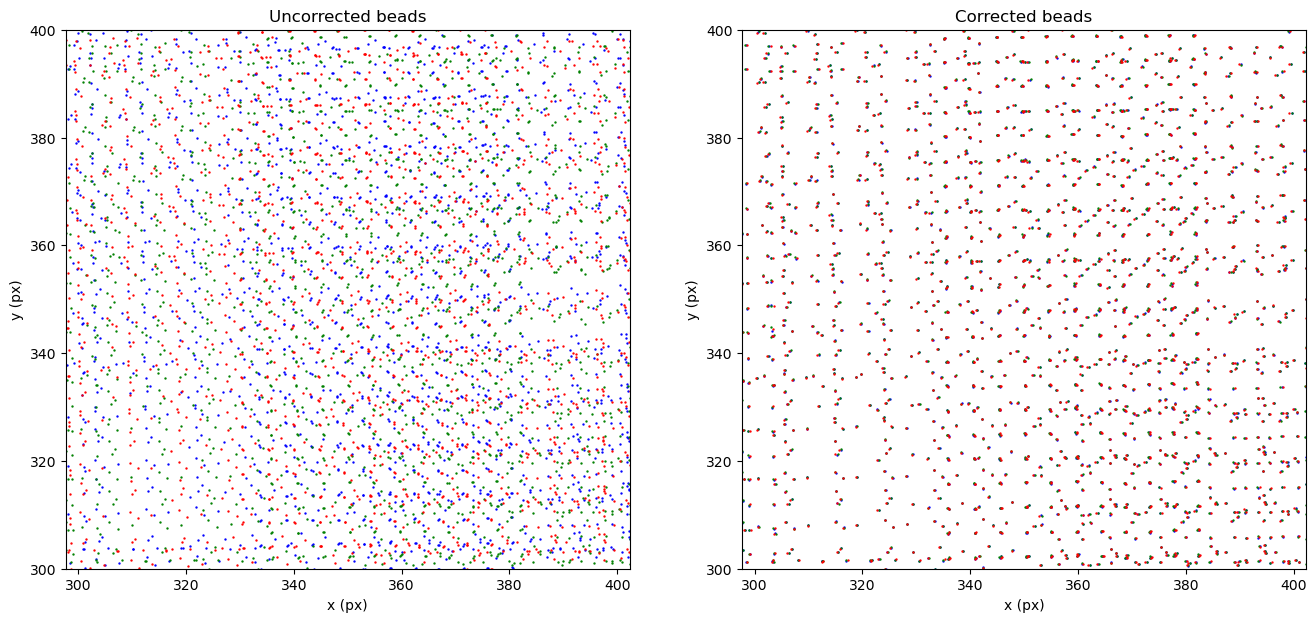

In [16]:
# Show localization improvement zoomed in
# Original grid.
fig = plt.figure(figsize=(16, 7))
fig.add_subplot(121)
plt.title('Original spots - center of image')
color = ['b', 'g', 'r']
for k in [0, 1, 2]:
    plt.scatter(points[k][:, 0], points[k][:, 1], c=color[k], marker='.', s=2)
    plt.xlabel('x (px)')
    plt.ylabel('y (px)')
    plt.axis('equal')
    plt.title('Uncorrected beads')
    plt.xlim([300, 400])
    plt.ylim([300, 400])
    # plt.legend(['Channel 0','Channel 1','Channel 2'])

# Corrected grid.
fig.add_subplot(122)
plt.scatter(locs0_corrected[:, 0], locs0_corrected[:, 1], c='b', marker='.', s=2)
plt.scatter(points[1][:, 0], points[1][:, 1], c='g', marker='.', s=2)
plt.scatter(locs2_corrected[:, 0], locs2_corrected[:, 1], c='r', marker='.', s=2)
plt.xlabel('x (px)')
plt.ylabel('y (px)')
plt.axis('equal')
plt.xlim([300, 400])
plt.ylim([300, 400])
plt.title('Corrected beads')
# plt.legend(['Channel 0','Channel 1','Channel 2'])
plt.savefig(os.path.join(path, 'plots', '_corrected.png'),
            dpi=200, bbox_inches='tight', transparent=False)
plt.show()
plt.close()